# Finetune InceptionV4 on Caltech101

## Install and import required packages

In [2]:
%%capture
!pip install timm
!pip install deephys

In [3]:
import torch
import torchvision
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

import timm
import deephys as dp

## Data Processing

In [4]:
def enforce_rgb(x):
    return x.convert('RGB')

def load_data(test_split=0.2):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(enforce_rgb),
        torchvision.transforms.Resize((299, 299)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    dataset = torchvision.datasets.Caltech101(root="./data", download=True, transform=transform)
    num_classes = len(dataset.categories)

    num_samples = len(dataset)
    test_size = int(num_samples * test_split)
    train_size = num_samples - test_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    return train_dataset, test_dataset, num_classes

## Utility Functions

In [5]:
def load_checkpoint(checkpoint_path='model_checkpoint.pth'):
    if os.path.exists(checkpoint_path):
        print("=> Loading checkpoint")
        checkpoint = torch.load(checkpoint_path)
        start_epoch = checkpoint['epoch']
        print("=> Loaded checkpoint at epoch {}".format(start_epoch))
        return checkpoint, start_epoch
    else:
        print("=> No checkpoint found")
        return None, 0

def save_checkpoint(checkpoint_path, epoch, model_state_dict, optimizer_state_dict, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, precision_hist, recall_hist, f1_score_hist):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_state_dict,
        'optimizer_state_dict': optimizer_state_dict,
        'train_loss_hist': train_loss_hist,
        'test_loss_hist': test_loss_hist,
        'train_acc_hist': train_acc_hist,
        'test_acc_hist': test_acc_hist,
        'precision_hist': precision_hist,
        'recall_hist': recall_hist,
        'f1_score_hist': f1_score_hist
    }, checkpoint_path)

## Model training and validation helper functions

In [6]:
def train_epoch(model, device, train_loader, criterion, optimizer, epoch, train_loss_hist, train_acc_hist):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} (Training)", leave=False)
    train_loss = 0
    total_train_correct = 0
    total_train_images = 0
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_images += labels.size(0)
        train_acc = total_train_correct / total_train_images
        train_bar.set_postfix({"Loss": train_loss / total_train_images, "Accuracy": train_acc})

    train_loss_hist.append(train_loss/len(train_loader.dataset))
    train_acc_hist.append(train_acc)

    print(f"Epoch {epoch+1}\nTraining -> Train Loss: {train_loss_hist[-1]:.4f}, Train Accuracy: {train_acc_hist[-1]:.4f}")


    return train_loss_hist, train_acc_hist

In [7]:
def evaluate_model(model, device, criterion, test_loader, epoch, num_epochs, test_loss_hist, test_acc_hist, precision_hist, recall_hist, f1_score_hist):
    model.eval()
    test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1} (Testing)", leave=False)
    test_loss = 0
    total_test_correct = 0
    total_test_images = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            # test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test_correct += (predicted == labels).sum().item()
            total_test_images += labels.size(0)
            test_acc = total_test_correct / total_test_images
            test_bar.set_postfix({"Loss": test_loss / total_test_images, "Accuracy": test_acc})
            y_true += labels.cpu().numpy().tolist()
            y_pred += predicted.cpu().numpy().tolist()

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    test_loss_hist.append(test_loss/len(test_loader.dataset))
    test_acc_hist.append(test_acc)
    precision_hist.append(precision)
    recall_hist.append(recall)
    f1_score_hist.append(f1)

    print(f"Testing -> Test Loss: {test_loss_hist[-1]:.4f}, Test Accuracy: {test_acc_hist[-1]:.4f}, Precision: {precision_hist[-1]:.4f}, Recall: {recall_hist[-1]:.4f}, F1 Score: {f1_score_hist[-1]:.4f}\n")

    if epoch + 1 == num_epochs:
        print()
        print(classification_report(y_true, y_pred))
        print()


    return test_loss_hist, test_acc_hist, precision_hist, recall_hist, f1_score_hist

In [8]:
def plot_results(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, precision_hist, recall_hist, f1_score_hist):
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss_hist, label="Train Loss")
    plt.plot(test_loss_hist, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.show()

    print()

    plt.figure(figsize=(12, 6))
    plt.plot(train_acc_hist, label="Train Accuracy")
    plt.plot(test_acc_hist, label="Test Accuracy")
    plt.plot(precision_hist, label="Precision")
    # plt.plot(recall_hist, label="Recall") # Recall and Test Accuracy come out to be exactly the same
    plt.plot(f1_score_hist, label="F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.show()


In [9]:
def train_model(train_loader, test_loader, num_classes, num_epochs=10, checkpoint_path='model_checkpoint.pth'):
    # model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
    # model.fc = torch.nn.Linear(model.classifier.fc.in_features, num_classes)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

    model = timm.create_model('inception_v4', pretrained=True, num_classes=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    criterion = torch.nn.CrossEntropyLoss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    checkpoint, start_epoch = load_checkpoint(checkpoint_path)

    if checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        train_loss_hist = checkpoint['train_loss_hist']
        test_loss_hist = checkpoint['test_loss_hist']
        train_acc_hist = checkpoint['train_acc_hist']
        test_acc_hist = checkpoint['test_acc_hist']
        precision_hist = checkpoint['precision_hist']
        recall_hist = checkpoint['recall_hist']
        f1_score_hist = checkpoint['f1_score_hist']
    else:
        train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []
        precision_hist, recall_hist, f1_score_hist = [], [], []

    for epoch in range(start_epoch, num_epochs):
        train_loss_hist, train_acc_hist = train_epoch(model, device, train_loader, criterion, optimizer, epoch, train_loss_hist, train_acc_hist)
        test_loss_hist, test_acc_hist, precision_hist, recall_hist, f1_score_hist = evaluate_model(model, device, criterion, test_loader, epoch, num_epochs, test_loss_hist, test_acc_hist, precision_hist, recall_hist, f1_score_hist)
        save_checkpoint(checkpoint_path, epoch+1, model.state_dict(), optimizer.state_dict(), train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, precision_hist, recall_hist, f1_score_hist)

    plot_results(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, precision_hist, recall_hist, f1_score_hist)

    return model


## Training

In [10]:
train_dataset, test_dataset, num_classes = load_data(test_split=0.2)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


131740031it [00:00, 139955745.42it/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


14028800it [00:00, 124966129.68it/s]


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101


=> Loading checkpoint
=> Loaded checkpoint at epoch 11


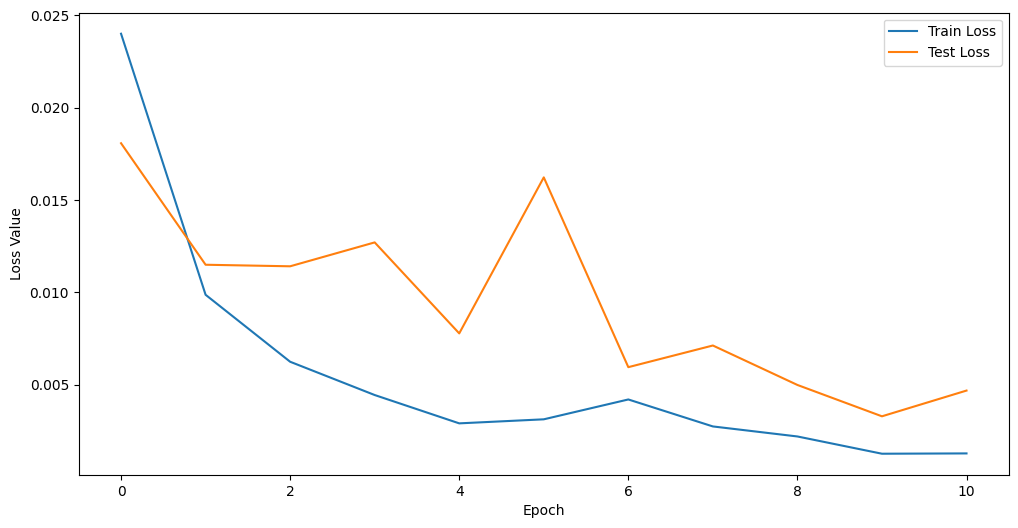

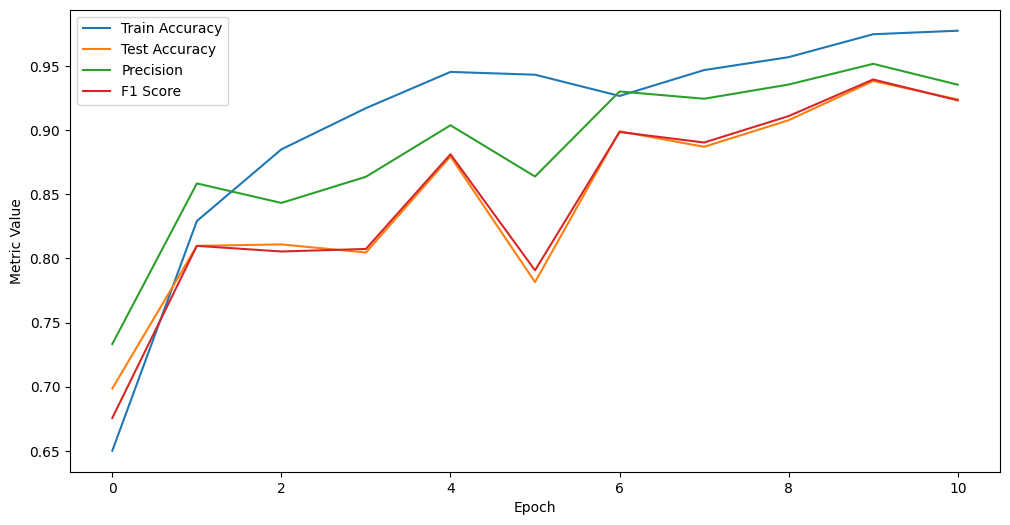

In [11]:
num_epochs = 11
model = train_model(train_loader, test_loader, num_classes, num_epochs=num_epochs, checkpoint_path='/content/drive/MyDrive/caltech101/model_checkpoint.pth')

In [12]:
classes = torchvision.datasets.Caltech101(root="./data").categories
print(classes)

['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler

In [13]:
# This is helpful to figure out the name of the penultimate layer to extract the neural activations from. For InceptionV4, it was after 'gloabl_pool.'
print(model)

InceptionV4(
  (features): Sequential(
    (0): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (1): ConvNormAct(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (2): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (3): Mixed3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (c

# Deephys

## Hooks to extract neural activity

In [14]:
# Define hooks to extract the neural activity from the model
model_activity = {}
def get_activation(name):
  def hook(model, input, output):
    model_activity[name] = output.detach()
  return hook

In [15]:
# Register the hook with the model
h = model.global_pool.register_forward_hook(get_activation(name='linear1'))

## Function to extract everything needed for Deephys

In [16]:
def extract_activity(testloader, model):

  # All we need for Deephys
  dp_images = []
  dp_gt = []
  dp_activity = {
      "output": [],
      "linear1": []
  }

  # Standard normalization for ImageNet
  # normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
  #                                   std=[0.229, 0.224, 0.225])

  # Resize the data only for visualization in deephys
  resize = torchvision.transforms.Resize((64,64))

  # Loop across all dataset
  for data, target in iter(testloader):

      resized_data = resize(data)

      dp_images.append(resized_data)
      dp_gt.append(target)

      if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()

      with torch.no_grad():
        logits = model(data)
        outputs = torch.nn.functional.softmax(logits, dim=1).detach().cpu()
        dp_activity['output'].append(outputs)

        # Each time a batch of data is passed through the model, the forward hook stores the outputs of the global pool layer. We are appending them to dp_activity['linear1']
        tmp_activity = torch.squeeze(model_activity['linear1']).detach().cpu()
        dp_activity['linear1'].append(tmp_activity)

  # Convert torch tensors to numpy
  for layer in dp_activity:
        dp_activity[layer] = torch.cat(dp_activity[layer]).numpy()

  dp_images = torch.cat(dp_images).numpy()
  dp_gt = torch.cat(dp_gt).numpy()

  return dp_images, dp_gt, dp_activity

## Deephys model

In [17]:
dp_model = dp.model(
    name = "inception_v4",
    layers = {
        "linear1": model.last_linear.in_features,
        "output": len(classes)
    },
    classification_layer="output"
)

# dp_model.save('/content/drive/MyDrive/caltech101/inception_v4.model')
dp_model.save('/content/inception_v4.model')

Saving data to /content/inception_v4.model...
done saving data to /content/inception_v4.model


In [18]:
IN_images, IN_gt, IN_activity = extract_activity(test_loader, model)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [19]:
print(IN_images.shape)

(1735, 3, 64, 64)


## Process images and then export neural activity


In [20]:
# Normalized batch of images
normalized_batch = IN_images

# Mean and standard deviation values used for normalization
mean = np.array([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
std = np.array([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)

# Map back to original pixel values
original_batch = normalized_batch * std + mean

# Clip some values
original_batch = np.clip(original_batch, 0, 1)

In [21]:
dataset_activity = dp.dataset_activity(
    name = "Caltech101",
    category_names = classes,
    images = original_batch,
    groundtruth = IN_gt,
    neural_activity = IN_activity,
    model=dp_model,
    )

# dataset_activity.save('/content/drive/MyDrive/caltech101/Caltech101.test')
dataset_activity.save('/content/Caltech101.test')

Preparing data...


100%|██████████| 1735/1735 [00:01<00:00, 916.74it/s]


Saving data to /content/Caltech101.test...
done saving data to /content/Caltech101.test
